# Problem Understanding

The given problem is an image classification problem. Images of 12 different species at different growth stages are given. The task is to classify the images by the plant specie. The data is from [kaggle](https://www.kaggle.com/datasets/vbookshelf/v2-plant-seedlings-dataset/code).

An automized solution of this problem can be useful for farmers. In order to optimize the growth of crops, farmers need to identify the  specie of a plant after a few days. An automated classification by images can save time and therefore optimize this process, as explained in [Makanapura et al. 2022, Classification of plant seedlings using deep convolutional neural network architectures](https://iopscience.iop.org/article/10.1088/1742-6596/2161/1/012006/meta)

# Setup

Install needed libraries and import all packages needed in this notebook.

In [1]:
!pip install torcheval

In [6]:
import os
import glob
import copy
import shutil
import random
import time
import numpy as np
import pandas as pd
from tqdm import tqdm

# plotting
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# modelling and evaluation
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torchvision.models as models
from torcheval.metrics.functional import multiclass_f1_score
from sklearn.metrics import confusion_matrix, accuracy_score

# set a fixed random seed to make results reproducible
RANDOM_STATE = 42
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

# path to images
data_path = "data"

# Data Exploration


The  data folder contains two subfolders 'train' and 'test'. The 'train' folder contains 12 subsolders with the name of each specie as labels. The test folder contains images of different species without labels.

**Plot Random Subset for each class**

To get a first impression of the data we will read the 'train' data and plot a random subset of each species.


In [7]:
def plot_examples(data_path, split='train'):
    # subfolders of species
    subfolders = [x[0] for x in os.walk(os.path.join(data_path, f'{split}'))][1:]

    fig, axes = plt.subplots(12, 5, figsize=(12,20))
    for i, folder in enumerate(subfolders):
        images = glob.glob(f"{folder}/*.png")
        img_path = random.sample(images, 5)
        imgs = [cv2.imread(img) for img in img_path]
        for j in range(5):
            rgb_img = cv2.cvtColor(imgs[j], cv2.COLOR_BGR2RGB)
            axes[i, j].imshow(rgb_img)
            axes[i, j].set_title(subfolders[i].split('/')[-1], fontsize=10)
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([]);

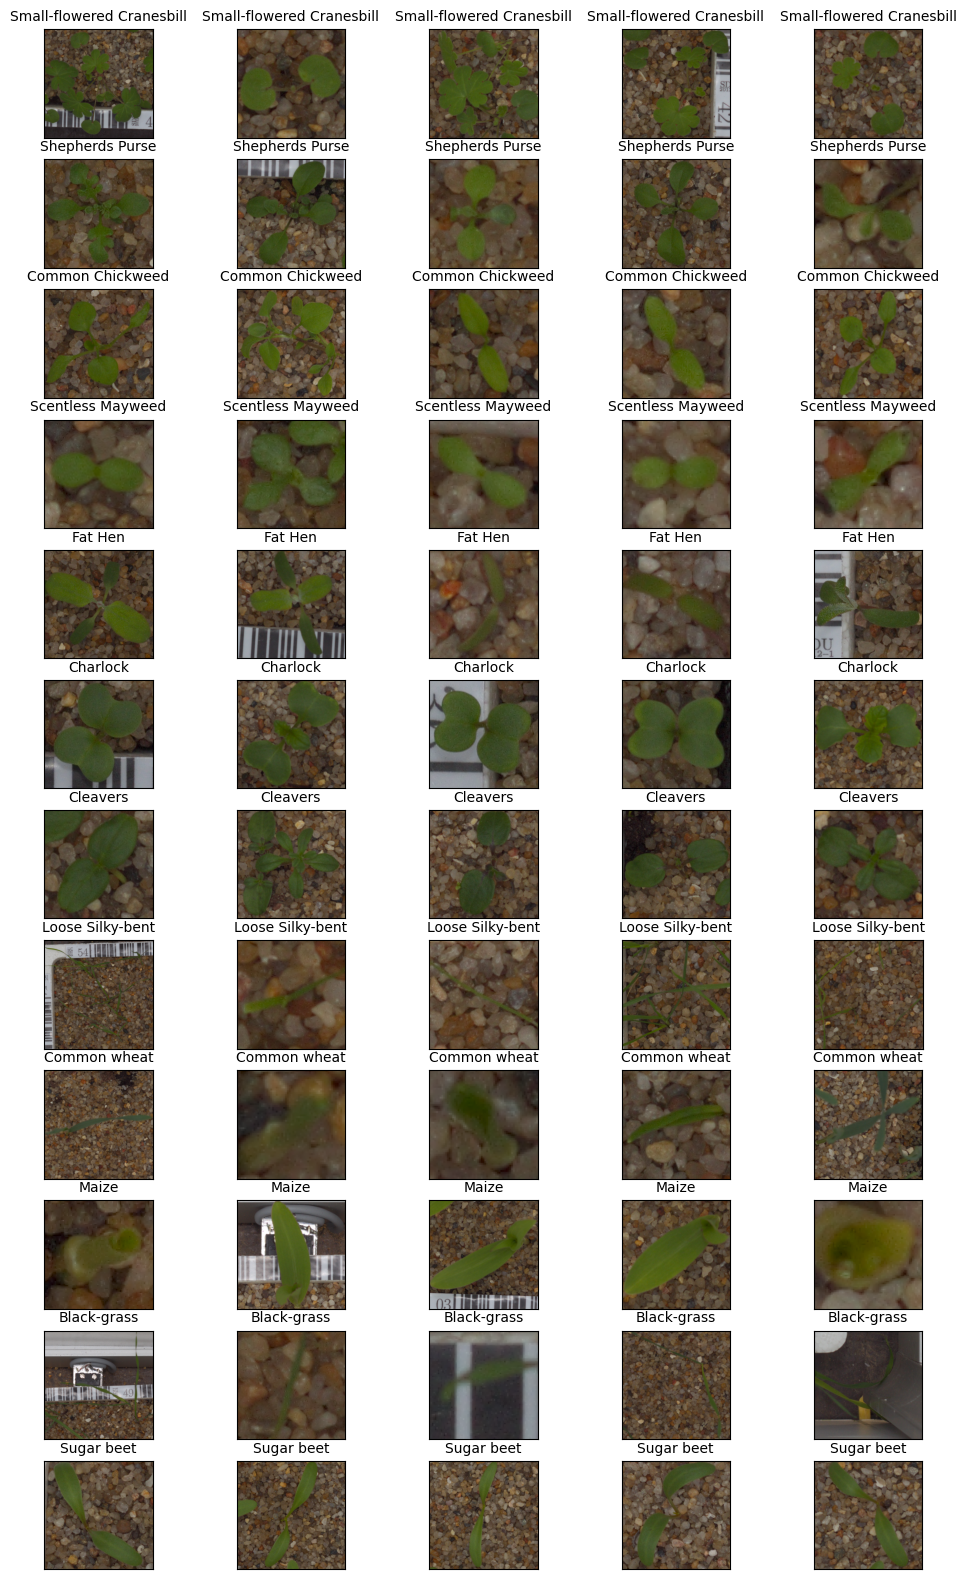

In [8]:
plot_examples(data_path, split='train')

**Check image sizes**

Check if images have the same size. If not, we need to resize them before training a model. We do that by looping over the images and reading their sizes in a list. We convert the list into a set and thereby elimate dublicates. If all images have the same size, in the end we have a set on length 1. If the length is larger than 1, the loop is interrupted and we know that not all images have the same size.

In [9]:
subfolders = [x[0] for x in os.walk(os.path.join(data_path, 'train'))][1:]
imgs_sizes = []
for folder in subfolders:
    images = glob.glob(f"{folder}/*.png")
    imgs_sizes.extend([cv2.imread(img).shape for img in images])
    if len(set(imgs_sizes)) > 1:
      print("Not all images have the same size.")
      break
    else:
      print("All images have the same size.")

Not all images have the same size.


**Number of images for each class**

Next we will check how many images for each class are available and the total number of images.

In [10]:
subfolders = [x[0] for x in os.walk(os.path.join(data_path, 'train'))][1:]
nr_img_class = {}
for folder in subfolders:
    specie = folder.split('/')[-1]
    images = glob.glob(f"{folder}/*.png")
    nr_img_class[f'{specie}'] = len(images)
print('Number of images for each class:')
print(nr_img_class)

Number of images for each class:
{'Small-flowered Cranesbill': 496, 'Shepherds Purse': 231, 'Common Chickweed': 611, 'Scentless Mayweed': 516, 'Fat Hen': 475, 'Charlock': 390, 'Cleavers': 287, 'Loose Silky-bent': 654, 'Common wheat': 221, 'Maize': 221, 'Black-grass': 263, 'Sugar beet': 385}


In [11]:
print(f'Total number of images for training and validation: {sum(nr_img_class.values())}')

Total number of images for training and validation: 4750


Illustrate the nr of images per class in a barplot.

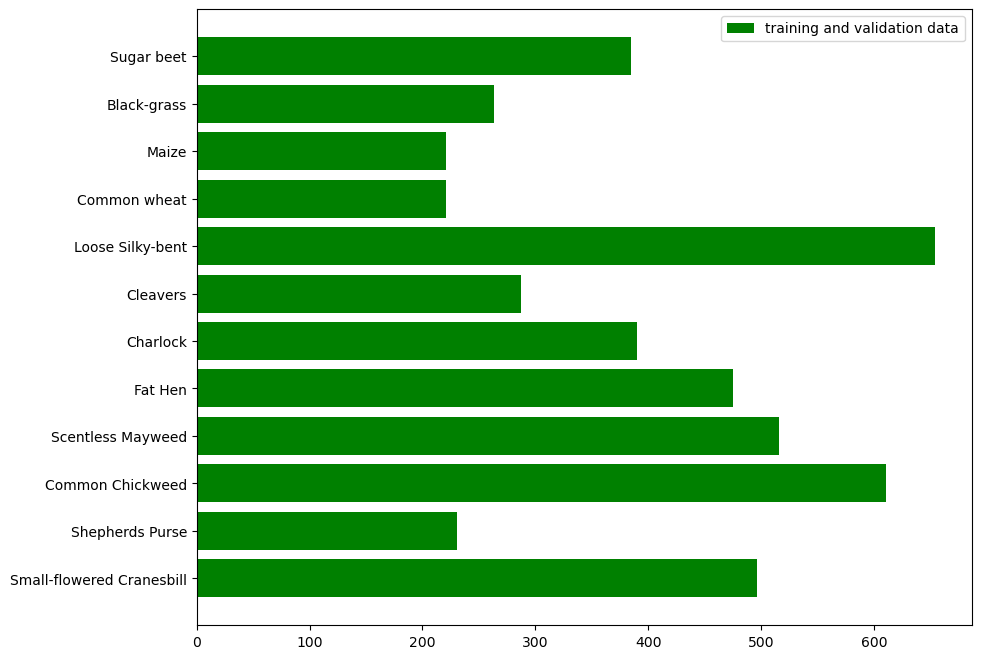

In [12]:
fig, ax = plt.subplots(figsize=(10,8))
ax.barh(list(nr_img_class.keys()), width=list(nr_img_class.values()), label='training and validation data', color='green')
ax.legend();

**Pixel Intensity**

We analyse the amount of each color (red, green, blue) in the images. Since all data is too much to process a random number of images from each class is drawn. For each of these images the red, green and blue channels are separated and then for each channel the rgb-values are combined and shown in a Histogram. That is the Histogram shows the rgb-channels of all images for each class. This makes it possible to see, if there are differences within the classes or any conspicuous peaks. Unfortunately this takes very long and only a small subset is plottet.

In [13]:
def plot_pixel_intensities(data_path, splits=['train'], draw_random=100):
    # subfolders of species
    fig, axes = plt.subplots(12, len(splits), figsize=(6,15))
    fig.tight_layout()
    for i, ax in enumerate(range(12)):
        for s, split in enumerate(splits):
            subfolders = [x[0] for x in os.walk(os.path.join(data_path, f'{split}'))][1:]

            folder = subfolders[i]
            images = glob.glob(f"{folder}/*.png")
            img_path = random.sample(images, draw_random)

            imgs_red = [list(cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)[:,:,0].flatten()) for img in img_path]
            imgs_green = [list(cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)[:,:,1].flatten()) for img in img_path]
            imgs_blue = [list(cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)[:,:,2].flatten()) for img in img_path]
            imgs_red_one = [item for row in imgs_red for item in row]
            imgs_green_one = [item for row in imgs_green for item in row]
            imgs_blue_one = [item for row in imgs_blue for item in row]
            n_bins = 50
            axes[i].hist(imgs_red_one, bins= n_bins, lw = 0, color='r', alpha=0.5, density=True);
            axes[i].hist(imgs_green_one, bins= n_bins, lw = 0, color='g', alpha=0.5, density=True);
            axes[i].hist(imgs_blue_one, bins= n_bins, lw = 0, color='b', alpha=0.5, density=True);
            axes[i].set_title(f"Pixel Intensity {split} - {folder.split('/')[-1]}", fontsize=10)

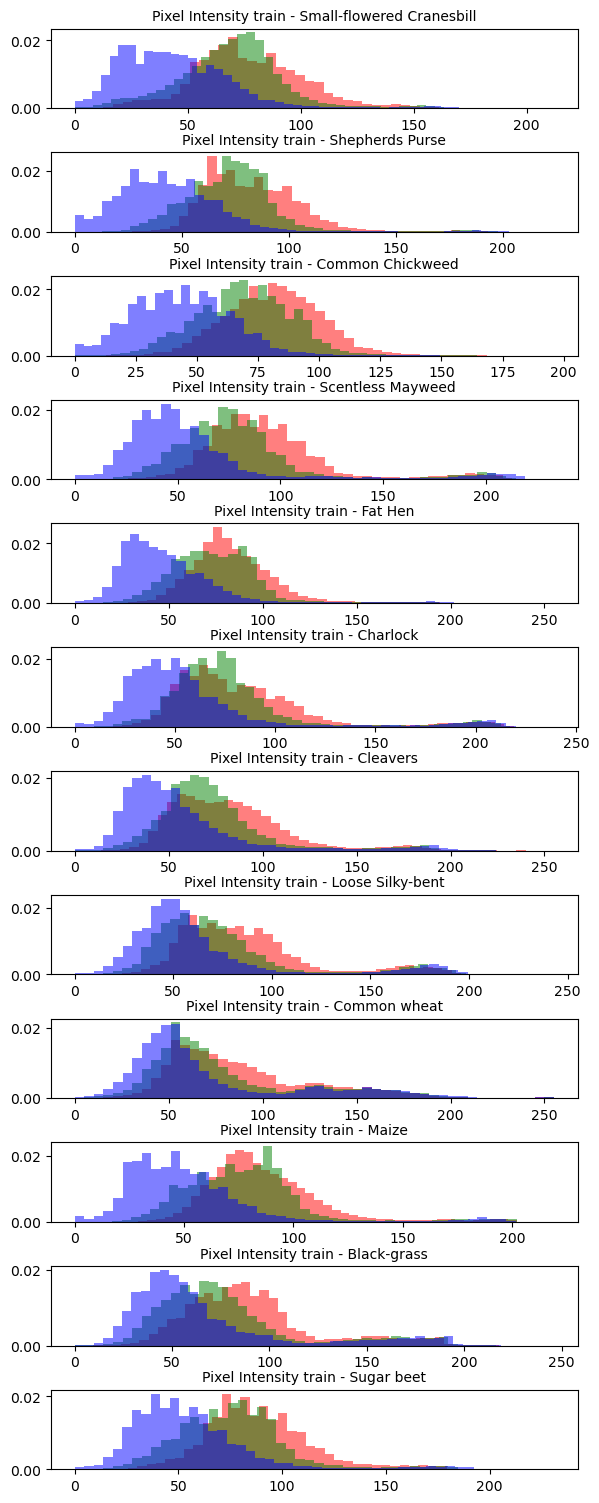

In [14]:
plot_pixel_intensities(data_path, splits=['train'], draw_random=10)

**Observations**:

From the above analysis, we have the following observations.

* The images have different sizes
* The images have 3 channels
* All plants are green
* Most of the images have a similar background of small stones in a grey / brown color
* On several images a tape measure can be seen, which is black and white
* Some images are blurred
* The distance of the camera vary on the images
* The data is not equally distributed over all classes

# Data Preparation

**Image Preprocessing**

As we observed all plants have the same color (green), that is the main information should come from the shape of the plant. Also, the measurement tape in the images may irritate the model and it may use this to classify the images, which we don't want. The measurement tape is only an artefact and gives no information about the specie. In order to overcome this, we will preprocess the image such that the background is removed. We will use different functions from the cv2-library to achieve that. I found a set of functions from a kaggle Notebook by [Johannes Heller](https://www.kaggle.com/code/stopwhispering/plant-seedlings-class-from-img-pytorch-cnn) very useful. I used these functions to define a custom transformation class, which we can later use to transform the data before training.

The steps applied are the following:
* The image is converted to Hue-Saturation
* A binary mask is created by
    * Thresholding
    * Improve mask through morphology operation
* The binary mask and the image are combined using bitwise addition
* The image is sharpened

In [15]:
class MaskImage(object):
    """
    Mask input image to remove background.
    input: image as numpy array or PIL image
    output: PIL image with background removed
    """

    def __call__(self, image):
        # PyTorch ImageFolder reads images as PIL images
        # In order to work with cv library they have to be transformed to a numpy array
        if isinstance(image, Image.Image):
            image = np.array(image)
        image_hsv = self.convert_image_to_hsv(image)
        image_mask = self.create_mask_for_plant(image_hsv)
        image_masked = self.mask_plant(image, image_mask)
        image_sharpen = self.sharpen_image(image_masked)
        return Image.fromarray(np.uint8(image_sharpen)).convert('RGB')

    def convert_image_to_hsv(self, image):
        # convert from Blue-Green-Red to Hue-Saturation-Value color model
        # this makes it easier to represent a color range
        image_hsv = cv2.cvtColor(src=image, code=cv2.COLOR_BGR2HSV)
        return image_hsv

    def create_mask_for_plant(self, image_hsv):
        # create binary mask
        sensitivity = 35
        lower_hsv = np.array([60 - sensitivity, 100, 50])
        upper_hsv = np.array([60 + sensitivity, 255, 255])

        mask = cv2.inRange(src=image_hsv, lowerb=lower_hsv, upperb=upper_hsv)
        kernel = cv2.getStructuringElement(shape=cv2.MORPH_ELLIPSE, ksize=(11,11))
        mask = cv2.morphologyEx(src=mask, op=cv2.MORPH_CLOSE, kernel=kernel)
        return mask

    def mask_plant(self, image, mask):
        # take only the region of the mask from the image
        output = cv2.bitwise_and(src1=image, src2=image, mask=mask)
        return output

    def sharpen_image(self, image):
        # apply gaussian filter to image
        image_blurred = cv2.GaussianBlur(src=image,
                                          ksize=(0, 0),
                                          sigmaX=3)
        # Calculate the weighted sum of image and blurred image
        image_sharp = cv2.addWeighted(src1=image,
                                        alpha=1.5,
                                        src2=image_blurred,
                                        beta=-0.5,
                                        gamma=0)
        return image_sharp

Apply image preprocess methods to a random example image.

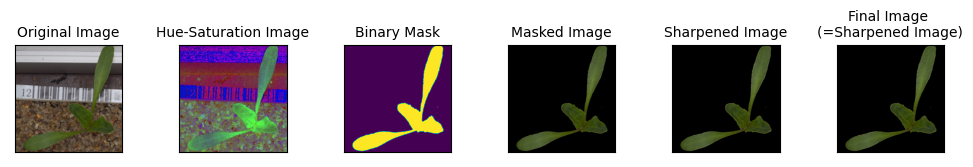

In [68]:
# read random image
subfolders = [x[0] for x in os.walk(os.path.join(data_path, 'train'))][1:]
for i, folder in enumerate(subfolders):
    images = glob.glob(f"{folder}/*.png")
    img_path = random.sample(images, 1)[0]
    image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

# instantiate class
mask_img = MaskImage()

# apply steps to remove background
image_hsv = mask_img.convert_image_to_hsv(image)
image_mask = mask_img.create_mask_for_plant(image_hsv)
image_masked = mask_img.mask_plant(image, image_mask)
image_sharpen = mask_img.sharpen_image(image_masked)

final_img = mask_img(image)

# plot single steps and final result
fig, axs = plt.subplots(1, 6, figsize=(10, 20))
fig.tight_layout(pad=1.0)

axs[0].imshow(image)
axs[0].set_title('Original Image', fontsize=10)
axs[1].imshow(image_hsv)
axs[1].set_title('Hue-Saturation Image', fontsize=10)
axs[2].imshow(image_mask)
axs[2].set_title('Binary Mask', fontsize=10)
axs[3].imshow(image_masked)
axs[3].set_title('Masked Image', fontsize=10)
axs[4].imshow(image_sharpen)
axs[4].set_title('Sharpened Image', fontsize=10)
axs[5].imshow(final_img)
axs[5].set_title('Final Image \n(=Sharpened Image)', fontsize=10)
for i in range(6):
    axs[i].set_xticks([])
    axs[i].set_yticks([])

**Create Training and Validation Splits**

In order to train a model we need to divide the data in the 'train' folder in training and validation data. We will create the validation data, such that it contains 20% of the images of each species. In that way the proportion of each species in training and validation remains the same.

We will use PyTorch to define and train a model. PyTorch provides [ImageFolder](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html) as a dataloader for image data. This is very convinient and we will use it in this task. In order to that, the data needs to be stored in a specific folder structure:

```
|--train_data
|  |--class1
|  |  |--image1.png
|  |  |--image2.png
|  |--class2
|  |  |--image1.png
|  |  |--image2.png
|--valid_data
|  |--class1
|  |  |--image1.png
|  |  |--image2.png
|  |--class2
|  |  |--image1.png
|  |  |--image2.png
```
Currently we have all data for training and validation in one folder. We will now select our validation data as explained above and save the images accordingly in two new folders 'train_data' and 'valid_data' which are created in this Colab Notebook and accessible through it.

In [17]:
# random seed needs to be set in cell
random.seed(RANDOM_STATE)
def create_train_valid_split(data_path, valid_percent=0.2):
    # subfolders of species
    subfolders =[x[0] for x in os.walk(os.path.join(data_path, 'train'))][1:]

    # check if folders already exist
    if not os.path.exists('train_data'):
        os.makedirs('train_data')
    if not os.path.exists('valid_data'):
        os.makedirs('valid_data')

    for folder in subfolders:
        specie = folder.split('/')[-1]
        images = glob.glob(f"{folder}/*.png")

        # select randomly valid_percent (default: 20%) of the images for each species
        sel_valid = int(len(images)*valid_percent)
        img_valid = random.sample(images, sel_valid)
        img_train = list(set(images)-set(img_valid))

        # if folders don't exist, create them and copy images
        if not os.path.exists(f'train_data/{specie}'):
            os.makedirs(f'train_data/{specie}')
            for img in img_train:
                shutil.copy(img, f'train_data/{specie}')

        if not os.path.exists(f'valid_data/{specie}'):
            os.makedirs(f'valid_data/{specie}')
            for img in img_valid:
                shutil.copy(img, f'valid_data/{specie}')

In [18]:
create_train_valid_split(data_path)

**Define a Model**

We will use a pretrained model. There are a lot of already trained models for image classification, we can save time and resources by using a pretrained model and adapt it to our use case. We will use the [VGG16](https://pytorch.org/vision/main/models/generated/torchvision.models.vgg16.html) model, which is available in PyTorch.

VGG16 was trained on the [ImageNet](https://www.image-net.org/) dataset, which consists of 1000 different classes. We have to adapt it to our use case. In the below cell we can see the structure of VGG16. We will adapt the classifier, so that 12 classes are predicted.

In [19]:
models.vgg16()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Define the adapted model for our use case.

We freeze the weights of the model and use the pretrained weights, i.e. only the classifier is trained. Also the classifier is slightly changed by changing the dropout probability from 0.5 to 0.4.

In [20]:
class PlantClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        weights = "VGG16_Weights.IMAGENET1K_V1"
        self.model = models.vgg16(
                weights=weights)

        # Freeze model weights
        for param in self.model.parameters():
            param.requires_grad = False

        # adapt classifier
        self.model.classifier = nn.Sequential(
                nn.Linear(25088, 4096, bias=True),
                nn.ReLU(inplace=True),
                nn.Dropout(0.4),
                nn.Linear(4096, 2048, bias=True),
                nn.ReLU(inplace=True),
                nn.Dropout(0.4),
                nn.Linear(2048, 12), # 12 classes
            )

    def forward(self, x):
        return self.model(x)

**Create Training and Validation Datasets**

We now create Datasets for training and validation.

Since we are using VGG16, we will do the same transformations to our validation data as were done in the original model. During training we add some more transformations for data augmentation, such as horizontal and vertical flipping, and random rotation of the image. We also add our custom transformation to remove the background. We apply this in the very beginning and then apply the remaining transformations to the preprocessed image. In the following cell, we can see the preprocessing steps (transformations) of VGG16.

In [21]:
weights = models.VGG16_Weights.IMAGENET1K_V1
preprocess = weights.transforms()
preprocess

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [22]:
train_transforms = transforms.Compose([MaskImage(),
                                       transforms.Resize(256),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.RandomRotation(degrees=180),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                          (0.485, 0.456, 0.406),
                                          (0.229, 0.224, 0.225)
                                          )
                                      ])
valid_transforms = transforms.Compose([MaskImage(),
                                       transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                          (0.485, 0.456, 0.406),
                                          (0.229, 0.224, 0.225)
                                          )
                                      ])

datadir_train = "train_data"
datadir_valid = "valid_data"

train_data = datasets.ImageFolder(datadir_train,
                    transform=train_transforms)
valid_data = datasets.ImageFolder(datadir_valid,
                    transform=valid_transforms)

In [23]:
# confirm classes
print(f'classes in training data: {train_data.classes}')
print(f'classes in validation data: {valid_data.classes}')

classes in training data: ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
classes in validation data: ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


**Plot Class Distributions for Training and Validation Data**

We chose 20% of each specie as validation data. Let's confirm the proportion and illustrate it in a barplot.

In [24]:
classes = train_data.classes
train_imgs = {}
valid_imgs = {}
for class_ in classes:
    train_imgs[class_] = len(glob.glob(f'train_data/{class_}/*'))
    valid_imgs[class_] = len(glob.glob(f'valid_data/{class_}/*'))
print(f'training data: {train_imgs}')
print(f'validation data: {valid_imgs}')
print(f'total training data: {sum(train_imgs.values())}')
print(f'total validation data: {sum(valid_imgs.values())}')
print(f'proportion of training data: {(sum(train_imgs.values())/(sum(train_imgs.values())+sum(valid_imgs.values())))*100:.2f}%')
print(f'proportion of validation data: {(sum(valid_imgs.values())/(sum(train_imgs.values())+sum(valid_imgs.values())))*100:.2f}%')

training data: {'Black-grass': 211, 'Charlock': 312, 'Cleavers': 230, 'Common Chickweed': 489, 'Common wheat': 177, 'Fat Hen': 380, 'Loose Silky-bent': 524, 'Maize': 177, 'Scentless Mayweed': 413, 'Shepherds Purse': 185, 'Small-flowered Cranesbill': 397, 'Sugar beet': 308}
validation data: {'Black-grass': 52, 'Charlock': 78, 'Cleavers': 57, 'Common Chickweed': 122, 'Common wheat': 44, 'Fat Hen': 95, 'Loose Silky-bent': 130, 'Maize': 44, 'Scentless Mayweed': 103, 'Shepherds Purse': 46, 'Small-flowered Cranesbill': 99, 'Sugar beet': 77}
total training data: 3803
total validation data: 947
proportion of training data: 80.06%
proportion of validation data: 19.94%


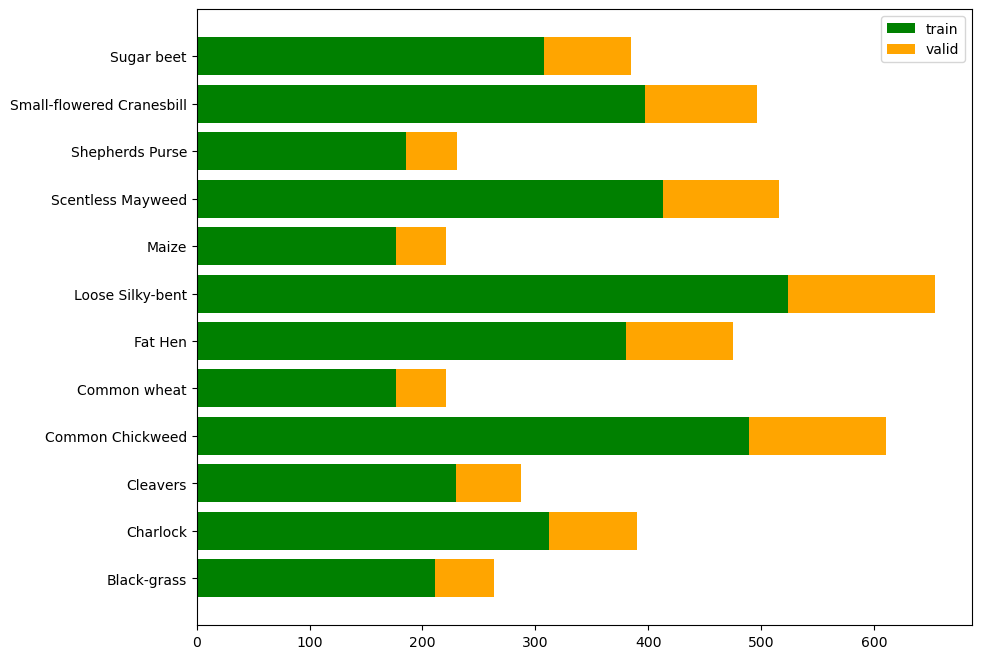

In [25]:
fig, ax = plt.subplots(figsize=(10,8))
ax.barh(list(train_imgs.keys()), width =  list(train_imgs.values()), label='train', color='green')
ax.barh(list(valid_imgs.keys()), width =  list(valid_imgs.values()), label='valid', color='orange', left=list(train_imgs.values()))
ax.legend();

# Modelling

**Define Training and Validation Loop**

To train a model we have to optimize it over several epochs. Within each epoch, we loop over all batches of our data. For training we optimize the weights using backpropagation, during validation the predictions are evaluated by calculating the loss. The two loops over training and validation batches are defined in the following two cells.

In [26]:
def train(model, device, dataloader, optimizer, criterion, epoch):
    '''
    parameters:
    model - the model used for training
    device - the device we work on (cpu or gpu)
    dataloader - the training data wrapped in a dataloader
    optimizer - the optimizer used for optimizing the parameters
    criterion - loss function
    epoch - current epoch
    '''

    # create empty list to store the train losses
    train_loss = []
    # create an empty list to store the predictions and true values
    train_pred = []
    train_true = []

    model.train()
    # loop over batches
    loop = tqdm(dataloader)
    for x, y in loop:
        # set data to device
        x, y = x.to(device), y.to(device)
        # set optimizer to zero
        optimizer.zero_grad()
        # apply model
        y_hat = model(x)
        # calculate loss
        loss = criterion(y_hat, y)
        # backpropagation
        loss.backward()
        train_loss.append(loss.item())

        # update the weights
        optimizer.step()
        loop.set_description(f"Train Epoch {epoch+1}/{epochs}")
        loop.set_postfix(loss=loss.item())

        # to get the predictions, we need to find the index with the highest predicted propability
        y_pred = y_hat.argmax(dim=-1, keepdims=True)
        train_pred.append(y_pred.flatten())
        train_true.append(y)

    # total training loss over all batches
    train_loss = torch.mean(torch.tensor(train_loss))
    train_pred = torch.concat(train_pred, axis=0)
    train_true = torch.concat(train_true, axis=0)

    print(f"Training: Average loss: {train_loss.item():.4f}")
    return train_loss.detach(), train_pred.detach(), train_true.detach()

In [27]:
def valid(model, device, dataloader, epoch):
    '''
    parameters:
    model - the model used for training
    device - the device we work on (cpu or gpu)
    dataloader - the training data wrapped in a dataloader
    epoch - current epoch
    '''

    # create empty list to store the train losses
    valid_loss = []
    # create an empty list to store the predictions and true values
    valid_pred = []
    valid_true = []

    model.eval()
    with torch.no_grad():
        # loop over batches
        loop = tqdm(dataloader)
        for x, y in loop:
            # set data to device
            x, y = x.to(device), y.to(device)
            # apply model
            y_hat = model(x)
            # calculate loss
            loss = criterion(y_hat, y)
            valid_loss.append(loss.item())

            loop.set_description(f"Valid Epoch {epoch+1}/{epochs}")
            loop.set_postfix(loss=loss.item())

            # to get the predictions, we need to find the index with the highest predicted propability
            y_pred = y_hat.argmax(dim=-1, keepdims=True)
            valid_pred.append(y_pred.flatten())
            valid_true.append(y)

        # total training loss over all batches
        valid_loss = torch.mean(torch.tensor(valid_loss))
        valid_pred = torch.concat(valid_pred, axis=0)
        valid_true = torch.concat(valid_true, axis=0)

    print(f"Validation: Average loss: {valid_loss.item():.4f}")
    return valid_loss.detach(), valid_pred.detach(), valid_true.detach()

**Set Hyperparameters**

To train the model we need to set some hyperparameters. For this example we will fix them, in a real-world scenario we would make them flexible and tune them to achieve optimized results.

As optimizer we choose the 'Adam-Optimizer', which is an extended version of Stochastic Gradiend. It uses estimations of the first and second moments of the gradient to adapt the learning rate for each weight of the neural network.  As loss we use 'Cross-Entropy-Loss'. This is a suitable loss for multiple classification. Because our data is not equally distributed over all classes one option to treat that is to use class weights in the loss.  We choose the class weights to be the reciprocal frequency. This emphasizes classes with fewer data.

In [28]:
# hyperparameters
batch_size = 32
epochs = 50
learning_rate = 0.001
patience = 10 # if no improvement for nr of patient epochs, earliy stopping

# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'the device used is: {device}')
# instantiate model and set it to device
model = PlantClassifier().to(device)
# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# define loss with weights
class_weights = torch.tensor([1/val for val in train_imgs.values()])
criterion = nn.CrossEntropyLoss(weight=class_weights)

the device used is: cpu


**Load the Data**

We load the data in batches using the PyTorch Dataloader iterable. This makes an easy processing of the data possible. For training we shuffle the data to avoid that the model learns due to a specific order in the data. For the validation this is not neccessary.

In [29]:
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_dataloader = DataLoader(valid_data, shuffle=False, batch_size=batch_size)

In [30]:
# print shape of images and labels of the first batch
print(f'image dataloader item: {next(iter(train_dataloader))[0].shape}')
print(f'label dataloader item: {len(next(iter(train_dataloader))[1])}')

image dataloader item: torch.Size([32, 3, 224, 224])
label dataloader item: 32


**Train the Model**

To train the model we apply the above defined training and validation loops for the number of epochs we want to train. We save the model, the loss and the predictions for the best model. The best model refers to the model with the lowest validation loss. The loss for each training and validation epoch is additionally stored for futher evaluation.

The metric referenced in the kaggle competition is the MeanFScore, also known as the micro-averaged f1-score. The f1-score is the harmonic mean of recall and precission for binary classification. The MeanFScore describes the generalization to multiple classes of this metric. It has values between 0 and 1, with 1 being the best value and 0 the worst. It is used, when both precision and recall are important, i.e. both False Positives and False Negatives should be avoided. In classification problems with unbalanced data as we have in this case, Precision and Recall are prefered compared to the Accuracy, because in highly unbalanced data a prediction of the majority class for all outcomes might lead to a high accuracy, but to a model that will never detect the minority class.

PyTorch provides the MeanFScore and we can directly calculate it for the predictions for each epoch. We will calculate and save the metric for training and validation data to see how the metric changes over the epochs.

In [31]:
train_epoch_loss = []
valid_epoch_loss = []
train_epoch_f1 = []
valid_epoch_f1 = []
best_valid_loss = 9999
best_epoch = -1
best_model = None
patience_count = 0

start_time = time.time()
for epoch in range(epochs):
    # train model for each epoch
    train_loss, train_pred, train_true = train(model, device, train_dataloader,
                                               optimizer, criterion, epoch)

    # validate model for each epoch
    valid_loss, valid_pred, valid_true = valid(model, device, valid_dataloader,
                                               epoch)
    train_epoch_loss.append(train_loss)
    valid_epoch_loss.append(valid_loss)
    # calculate MeanFScores
    train_meanf1 = multiclass_f1_score(train_true.reshape(-1,),
                                       train_pred.reshape(-1,),
                                       num_classes=12,
                                       average="micro")
    valid_meanf1 = multiclass_f1_score(valid_true.reshape(-1,),
                                       valid_pred.reshape(-1,),
                                       num_classes=12,
                                       average="micro")
    train_epoch_f1.append(train_meanf1)
    valid_epoch_f1.append(valid_meanf1)

    # save best model
    if valid_loss < best_valid_loss:
        print("new best valid loss")
        best_train_loss = train_loss
        best_valid_loss = valid_loss
        best_train_pred = train_pred
        best_valid_pred = valid_pred
        # save true values because of shuffeling
        best_train_true = train_true
        best_valid_true = valid_true
        best_epoch = epoch + 1
        best_model = copy.deepcopy(model)
        patience_count = 0
    else:
        patience_count += 1
    if patience_count == patience:
        print(f"\nbest epoch {best_epoch}: no further improvement for {patience} epochs")
        print(f"early stopping")
        break
print(f'Training took {(time.time()-start_time)/60:.3f} min.')

Train Epoch 1/50: 100%|████████████████████████████████████████████████████████████████| 119/119 [11:50<00:00,  5.97s/it, loss=0.83]


Training: Average loss: 1.3382


Valid Epoch 1/50: 100%|██████████████████████████████████████████████████████████████████| 30/30 [02:50<00:00,  5.69s/it, loss=1.28]


Validation: Average loss: 0.8482
new best valid loss


Train Epoch 2/50: 100%|███████████████████████████████████████████████████████████████| 119/119 [11:51<00:00,  5.98s/it, loss=0.697]


Training: Average loss: 0.7166


Valid Epoch 2/50: 100%|█████████████████████████████████████████████████████████████████| 30/30 [02:46<00:00,  5.54s/it, loss=0.365]


Validation: Average loss: 0.5453
new best valid loss


Train Epoch 3/50: 100%|███████████████████████████████████████████████████████████████| 119/119 [12:10<00:00,  6.14s/it, loss=0.409]


Training: Average loss: 0.6695


Valid Epoch 3/50: 100%|█████████████████████████████████████████████████████████████████| 30/30 [02:22<00:00,  4.76s/it, loss=0.328]


Validation: Average loss: 0.5345
new best valid loss


Train Epoch 4/50: 100%|███████████████████████████████████████████████████████████████| 119/119 [10:45<00:00,  5.43s/it, loss=0.244]


Training: Average loss: 0.6096


Valid Epoch 4/50: 100%|███████████████████████████████████████████████████████████████████| 30/30 [02:21<00:00,  4.73s/it, loss=0.6]


Validation: Average loss: 0.5588


Train Epoch 5/50: 100%|███████████████████████████████████████████████████████████████| 119/119 [10:36<00:00,  5.35s/it, loss=0.443]


Training: Average loss: 0.6063


Valid Epoch 5/50: 100%|█████████████████████████████████████████████████████████████████| 30/30 [02:19<00:00,  4.67s/it, loss=0.174]


Validation: Average loss: 0.6082


Train Epoch 6/50: 100%|███████████████████████████████████████████████████████████████| 119/119 [11:04<00:00,  5.58s/it, loss=0.606]


Training: Average loss: 0.5718


Valid Epoch 6/50: 100%|█████████████████████████████████████████████████████████████████| 30/30 [02:34<00:00,  5.13s/it, loss=0.251]


Validation: Average loss: 0.4830
new best valid loss


Train Epoch 7/50: 100%|███████████████████████████████████████████████████████████████| 119/119 [11:32<00:00,  5.82s/it, loss=0.545]


Training: Average loss: 0.5602


Valid Epoch 7/50: 100%|█████████████████████████████████████████████████████████████████| 30/30 [02:17<00:00,  4.60s/it, loss=0.666]


Validation: Average loss: 0.5693


Train Epoch 8/50: 100%|███████████████████████████████████████████████████████████████| 119/119 [11:34<00:00,  5.84s/it, loss=0.421]


Training: Average loss: 0.5484


Valid Epoch 8/50: 100%|█████████████████████████████████████████████████████████████████| 30/30 [02:20<00:00,  4.69s/it, loss=0.326]


Validation: Average loss: 0.4904


Train Epoch 9/50: 100%|███████████████████████████████████████████████████████████████| 119/119 [11:34<00:00,  5.83s/it, loss=0.445]


Training: Average loss: 0.5123


Valid Epoch 9/50: 100%|█████████████████████████████████████████████████████████████████| 30/30 [02:23<00:00,  4.79s/it, loss=0.372]


Validation: Average loss: 0.5851


Train Epoch 10/50: 100%|██████████████████████████████████████████████████████████████| 119/119 [11:09<00:00,  5.63s/it, loss=0.647]


Training: Average loss: 0.5717


Valid Epoch 10/50: 100%|████████████████████████████████████████████████████████████████| 30/30 [02:20<00:00,  4.68s/it, loss=0.746]


Validation: Average loss: 0.6323


Train Epoch 11/50: 100%|██████████████████████████████████████████████████████████████| 119/119 [11:50<00:00,  5.97s/it, loss=0.301]


Training: Average loss: 0.5100


Valid Epoch 11/50: 100%|████████████████████████████████████████████████████████████████| 30/30 [02:23<00:00,  4.77s/it, loss=0.617]


Validation: Average loss: 0.5980


Train Epoch 12/50: 100%|███████████████████████████████████████████████████████████████| 119/119 [11:34<00:00,  5.84s/it, loss=0.49]


Training: Average loss: 0.5627


Valid Epoch 12/50: 100%|████████████████████████████████████████████████████████████████| 30/30 [02:22<00:00,  4.75s/it, loss=0.247]


Validation: Average loss: 0.6745


Train Epoch 13/50: 100%|██████████████████████████████████████████████████████████████| 119/119 [11:32<00:00,  5.82s/it, loss=0.682]


Training: Average loss: 0.5392


Valid Epoch 13/50: 100%|████████████████████████████████████████████████████████████████| 30/30 [02:18<00:00,  4.60s/it, loss=0.649]


Validation: Average loss: 0.5672


Train Epoch 14/50: 100%|██████████████████████████████████████████████████████████████| 119/119 [10:44<00:00,  5.41s/it, loss=0.322]


Training: Average loss: 0.4996


Valid Epoch 14/50: 100%|████████████████████████████████████████████████████████████████| 30/30 [02:01<00:00,  4.04s/it, loss=0.473]


Validation: Average loss: 0.6431


Train Epoch 15/50: 100%|██████████████████████████████████████████████████████████████| 119/119 [11:04<00:00,  5.58s/it, loss=0.412]


Training: Average loss: 0.4717


Valid Epoch 15/50: 100%|████████████████████████████████████████████████████████████████| 30/30 [02:16<00:00,  4.54s/it, loss=0.384]


Validation: Average loss: 0.4542
new best valid loss


Train Epoch 16/50: 100%|██████████████████████████████████████████████████████████████| 119/119 [12:00<00:00,  6.06s/it, loss=0.289]


Training: Average loss: 0.5075


Valid Epoch 16/50: 100%|████████████████████████████████████████████████████████████████| 30/30 [02:39<00:00,  5.32s/it, loss=0.886]


Validation: Average loss: 0.6092


Train Epoch 17/50: 100%|██████████████████████████████████████████████████████████████| 119/119 [13:29<00:00,  6.81s/it, loss=0.125]


Training: Average loss: 0.4822


Valid Epoch 17/50: 100%|████████████████████████████████████████████████████████████████| 30/30 [02:42<00:00,  5.43s/it, loss=0.516]


Validation: Average loss: 0.5160


Train Epoch 18/50: 100%|██████████████████████████████████████████████████████████████| 119/119 [12:47<00:00,  6.45s/it, loss=0.319]


Training: Average loss: 0.5182


Valid Epoch 18/50: 100%|████████████████████████████████████████████████████████████████| 30/30 [02:22<00:00,  4.75s/it, loss=0.688]


Validation: Average loss: 0.5844


Train Epoch 19/50: 100%|███████████████████████████████████████████████████████████████| 119/119 [11:36<00:00,  5.85s/it, loss=1.04]


Training: Average loss: 0.4804


Valid Epoch 19/50: 100%|████████████████████████████████████████████████████████████████| 30/30 [02:17<00:00,  4.57s/it, loss=0.727]


Validation: Average loss: 0.6097


Train Epoch 20/50: 100%|██████████████████████████████████████████████████████████████| 119/119 [13:07<00:00,  6.62s/it, loss=0.993]


Training: Average loss: 0.5377


Valid Epoch 20/50: 100%|████████████████████████████████████████████████████████████████| 30/30 [02:18<00:00,  4.60s/it, loss=0.632]


Validation: Average loss: 0.4738


Train Epoch 21/50: 100%|██████████████████████████████████████████████████████████████| 119/119 [11:16<00:00,  5.68s/it, loss=0.623]


Training: Average loss: 0.4402


Valid Epoch 21/50: 100%|████████████████████████████████████████████████████████████████| 30/30 [02:20<00:00,  4.69s/it, loss=0.575]


Validation: Average loss: 0.4745


Train Epoch 22/50: 100%|██████████████████████████████████████████████████████████████| 119/119 [10:22<00:00,  5.23s/it, loss=0.142]


Training: Average loss: 0.4536


Valid Epoch 22/50: 100%|██████████████████████████████████████████████████████████████████| 30/30 [02:12<00:00,  4.41s/it, loss=1.1]


Validation: Average loss: 0.4841


Train Epoch 23/50: 100%|██████████████████████████████████████████████████████████████| 119/119 [10:36<00:00,  5.35s/it, loss=0.745]


Training: Average loss: 0.4765


Valid Epoch 23/50: 100%|████████████████████████████████████████████████████████████████| 30/30 [02:12<00:00,  4.41s/it, loss=0.459]


Validation: Average loss: 0.4620


Train Epoch 24/50: 100%|██████████████████████████████████████████████████████████████| 119/119 [10:37<00:00,  5.36s/it, loss=0.206]


Training: Average loss: 0.4332


Valid Epoch 24/50: 100%|████████████████████████████████████████████████████████████████| 30/30 [02:21<00:00,  4.71s/it, loss=0.376]


Validation: Average loss: 0.4469
new best valid loss


Train Epoch 25/50: 100%|██████████████████████████████████████████████████████████████| 119/119 [11:23<00:00,  5.74s/it, loss=0.527]


Training: Average loss: 0.4158


Valid Epoch 25/50: 100%|████████████████████████████████████████████████████████████████| 30/30 [02:18<00:00,  4.61s/it, loss=0.424]


Validation: Average loss: 0.4976


Train Epoch 26/50: 100%|██████████████████████████████████████████████████████████████| 119/119 [11:10<00:00,  5.64s/it, loss=0.439]


Training: Average loss: 0.4073


Valid Epoch 26/50: 100%|████████████████████████████████████████████████████████████████| 30/30 [02:20<00:00,  4.68s/it, loss=0.238]


Validation: Average loss: 0.4862


Train Epoch 27/50: 100%|██████████████████████████████████████████████████████████████| 119/119 [11:28<00:00,  5.78s/it, loss=0.411]


Training: Average loss: 0.4616


Valid Epoch 27/50: 100%|████████████████████████████████████████████████████████████████| 30/30 [02:16<00:00,  4.54s/it, loss=0.513]


Validation: Average loss: 0.5676


Train Epoch 28/50: 100%|██████████████████████████████████████████████████████████████| 119/119 [11:25<00:00,  5.76s/it, loss=0.217]


Training: Average loss: 0.4360


Valid Epoch 28/50: 100%|████████████████████████████████████████████████████████████████| 30/30 [02:22<00:00,  4.74s/it, loss=0.247]


Validation: Average loss: 0.4690


Train Epoch 29/50: 100%|██████████████████████████████████████████████████████████████| 119/119 [11:28<00:00,  5.78s/it, loss=0.338]


Training: Average loss: 0.4424


Valid Epoch 29/50: 100%|████████████████████████████████████████████████████████████████| 30/30 [02:22<00:00,  4.74s/it, loss=0.218]


Validation: Average loss: 0.4502


Train Epoch 30/50: 100%|██████████████████████████████████████████████████████████████| 119/119 [11:38<00:00,  5.87s/it, loss=0.179]


Training: Average loss: 0.4261


Valid Epoch 30/50: 100%|█████████████████████████████████████████████████████████████████| 30/30 [02:23<00:00,  4.78s/it, loss=0.67]


Validation: Average loss: 0.4340
new best valid loss


Train Epoch 31/50: 100%|██████████████████████████████████████████████████████████████| 119/119 [11:32<00:00,  5.82s/it, loss=0.152]


Training: Average loss: 0.4406


Valid Epoch 31/50: 100%|████████████████████████████████████████████████████████████████| 30/30 [02:23<00:00,  4.79s/it, loss=0.539]


Validation: Average loss: 0.4348


Train Epoch 32/50: 100%|██████████████████████████████████████████████████████████████| 119/119 [11:25<00:00,  5.76s/it, loss=0.151]


Training: Average loss: 0.4114


Valid Epoch 32/50: 100%|████████████████████████████████████████████████████████████████| 30/30 [02:21<00:00,  4.73s/it, loss=0.173]


Validation: Average loss: 0.4391


Train Epoch 33/50: 100%|██████████████████████████████████████████████████████████████| 119/119 [11:25<00:00,  5.76s/it, loss=0.109]


Training: Average loss: 0.4296


Valid Epoch 33/50: 100%|████████████████████████████████████████████████████████████████| 30/30 [02:21<00:00,  4.72s/it, loss=0.192]


Validation: Average loss: 0.4511


Train Epoch 34/50: 100%|██████████████████████████████████████████████████████████████| 119/119 [11:25<00:00,  5.76s/it, loss=0.152]


Training: Average loss: 0.4010


Valid Epoch 34/50: 100%|████████████████████████████████████████████████████████████████| 30/30 [02:23<00:00,  4.80s/it, loss=0.249]


Validation: Average loss: 0.4751


Train Epoch 35/50: 100%|███████████████████████████████████████████████████████████████| 119/119 [11:32<00:00,  5.82s/it, loss=0.38]


Training: Average loss: 0.4480


Valid Epoch 35/50: 100%|████████████████████████████████████████████████████████████████| 30/30 [02:21<00:00,  4.71s/it, loss=0.277]


Validation: Average loss: 0.4329
new best valid loss


Train Epoch 36/50: 100%|██████████████████████████████████████████████████████████████| 119/119 [11:30<00:00,  5.80s/it, loss=0.317]


Training: Average loss: 0.4527


Valid Epoch 36/50: 100%|████████████████████████████████████████████████████████████████| 30/30 [02:16<00:00,  4.57s/it, loss=0.421]


Validation: Average loss: 0.4234
new best valid loss


Train Epoch 37/50: 100%|██████████████████████████████████████████████████████████████| 119/119 [11:34<00:00,  5.84s/it, loss=0.309]


Training: Average loss: 0.4526


Valid Epoch 37/50: 100%|████████████████████████████████████████████████████████████████| 30/30 [02:22<00:00,  4.74s/it, loss=0.422]


Validation: Average loss: 0.6026


Train Epoch 38/50: 100%|██████████████████████████████████████████████████████████████| 119/119 [11:30<00:00,  5.80s/it, loss=0.395]


Training: Average loss: 0.4306


Valid Epoch 38/50: 100%|████████████████████████████████████████████████████████████████| 30/30 [02:22<00:00,  4.76s/it, loss=0.579]


Validation: Average loss: 0.5095


Train Epoch 39/50: 100%|██████████████████████████████████████████████████████████████| 119/119 [11:34<00:00,  5.84s/it, loss=0.168]


Training: Average loss: 0.4280


Valid Epoch 39/50: 100%|████████████████████████████████████████████████████████████████| 30/30 [02:23<00:00,  4.79s/it, loss=0.174]


Validation: Average loss: 0.3884
new best valid loss


Train Epoch 40/50: 100%|██████████████████████████████████████████████████████████████| 119/119 [11:33<00:00,  5.83s/it, loss=0.496]


Training: Average loss: 0.4161


Valid Epoch 40/50: 100%|████████████████████████████████████████████████████████████████| 30/30 [02:22<00:00,  4.75s/it, loss=0.555]


Validation: Average loss: 0.5197


Train Epoch 41/50: 100%|█████████████████████████████████████████████████████████████| 119/119 [11:31<00:00,  5.81s/it, loss=0.0907]


Training: Average loss: 0.4525


Valid Epoch 41/50: 100%|████████████████████████████████████████████████████████████████| 30/30 [02:05<00:00,  4.17s/it, loss=0.264]


Validation: Average loss: 0.4028


Train Epoch 42/50: 100%|██████████████████████████████████████████████████████████████| 119/119 [10:49<00:00,  5.46s/it, loss=0.175]


Training: Average loss: 0.3979


Valid Epoch 42/50: 100%|████████████████████████████████████████████████████████████████| 30/30 [02:22<00:00,  4.74s/it, loss=0.383]


Validation: Average loss: 0.4360


Train Epoch 43/50: 100%|██████████████████████████████████████████████████████████████| 119/119 [10:34<00:00,  5.33s/it, loss=0.334]


Training: Average loss: 0.4398


Valid Epoch 43/50: 100%|██████████████████████████████████████████████████████████████████| 30/30 [02:02<00:00,  4.09s/it, loss=0.3]


Validation: Average loss: 0.4865


Train Epoch 44/50: 100%|██████████████████████████████████████████████████████████████| 119/119 [10:28<00:00,  5.28s/it, loss=0.392]


Training: Average loss: 0.3916


Valid Epoch 44/50: 100%|█████████████████████████████████████████████████████████████████| 30/30 [02:07<00:00,  4.26s/it, loss=0.43]


Validation: Average loss: 0.5025


Train Epoch 45/50: 100%|██████████████████████████████████████████████████████████████| 119/119 [10:17<00:00,  5.19s/it, loss=0.744]


Training: Average loss: 0.4501


Valid Epoch 45/50: 100%|████████████████████████████████████████████████████████████████| 30/30 [02:01<00:00,  4.05s/it, loss=0.248]


Validation: Average loss: 0.4303


Train Epoch 46/50: 100%|██████████████████████████████████████████████████████████████| 119/119 [10:08<00:00,  5.11s/it, loss=0.313]


Training: Average loss: 0.3943


Valid Epoch 46/50: 100%|█████████████████████████████████████████████████████████████████| 30/30 [02:00<00:00,  4.03s/it, loss=0.43]


Validation: Average loss: 0.4536


Train Epoch 47/50: 100%|██████████████████████████████████████████████████████████████| 119/119 [10:29<00:00,  5.29s/it, loss=0.316]


Training: Average loss: 0.4470


Valid Epoch 47/50: 100%|████████████████████████████████████████████████████████████████| 30/30 [02:00<00:00,  4.01s/it, loss=0.282]


Validation: Average loss: 0.4489


Train Epoch 48/50: 100%|██████████████████████████████████████████████████████████████| 119/119 [10:01<00:00,  5.05s/it, loss=0.138]


Training: Average loss: 0.4359


Valid Epoch 48/50: 100%|████████████████████████████████████████████████████████████████| 30/30 [01:59<00:00,  4.00s/it, loss=0.246]


Validation: Average loss: 0.5296


Train Epoch 49/50: 100%|██████████████████████████████████████████████████████████████| 119/119 [09:55<00:00,  5.01s/it, loss=0.487]


Training: Average loss: 0.4193


Valid Epoch 49/50: 100%|████████████████████████████████████████████████████████████████| 30/30 [02:00<00:00,  4.02s/it, loss=0.272]

Validation: Average loss: 0.4489

best epoch 39: no further improvement for 10 epochs
early stopping
Training took 668.692 min.


**Save best model**

We save the best model for further usage.

In [32]:
model_name = f"{model.__class__.__name__}_best_model.pth"
torch.save(best_model.state_dict(), model_name)

# Evaluate the Results

We plot the loss for training and validation over the epochs. The vertical line shows the epoch with the lowest validation loss, when the model was saved.


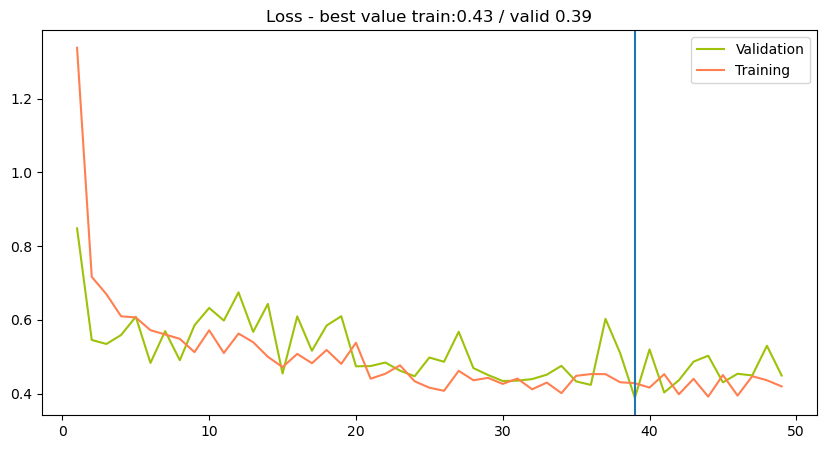

In [33]:
if patience_count == 10:
    epochs = best_epoch + patience
fig, ax = plt.subplots(1,1, figsize=(10,5))
x = np.arange(1, epochs+1)
ax.plot(x, valid_epoch_loss, label="Validation", color="#9DC209")
ax.plot(x, train_epoch_loss, label="Training", color="#FF7F50")
plt.axvline(x=best_epoch)
ax.legend()
ax.set_title(f"Loss - best value train:{train_epoch_loss[best_epoch-1]:.2} / valid {valid_epoch_loss[best_epoch-1]:.2}");

Accordingly we plot the MeanFScore over the epochs for training and validation.

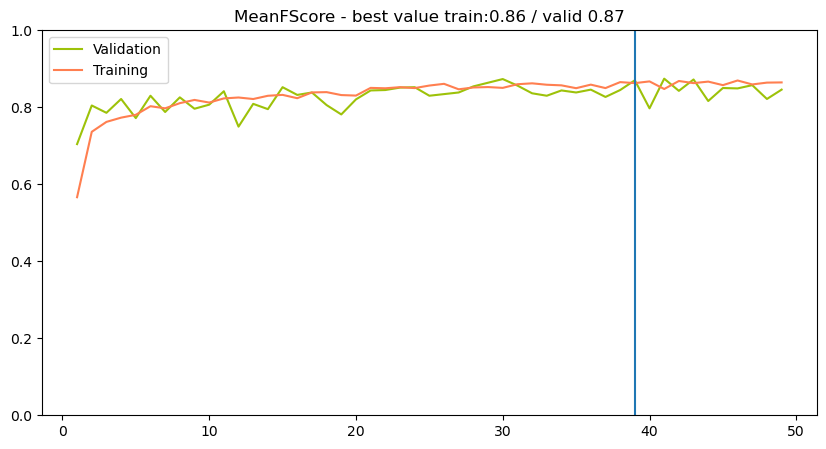

In [34]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
x = np.arange(1, epochs+1)
ax.plot(x, valid_epoch_f1, label="Validation", color="#9DC209")
ax.plot(x, train_epoch_f1, label="Training", color="#FF7F50")
plt.axvline(x=best_epoch)
ax.legend()
ax.set_ylim(0,1)
ax.set_title(f"MeanFScore - best value train:{train_epoch_f1[best_epoch-1]:.2} / valid {valid_epoch_f1[best_epoch-1]:.2}");

Additionally to the MeanFScore, we will have a look at the confusion matrix. The below plot shows the true values on the y-axes and the predicted values on the x-axes. 

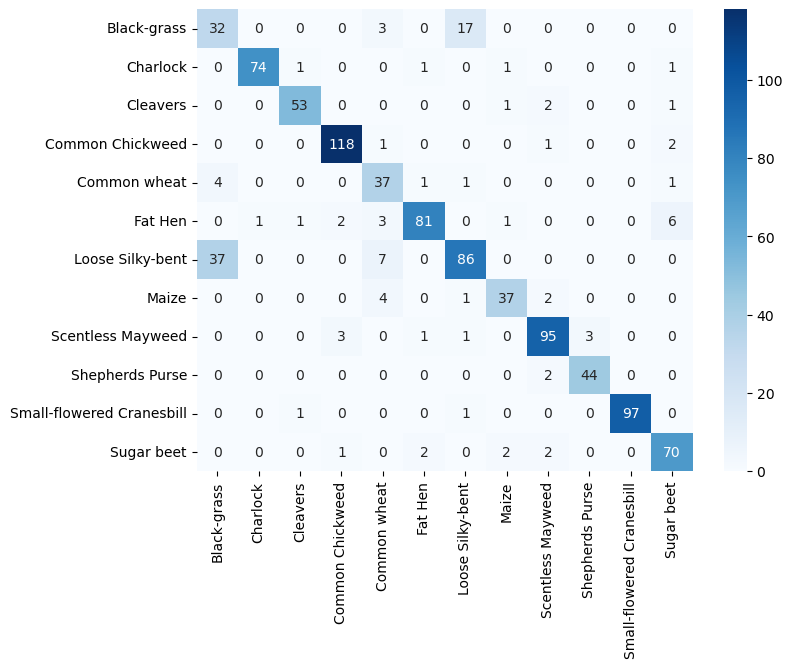

In [57]:
cm = confusion_matrix(best_valid_true.reshape(-1,), best_valid_pred.reshape(-1,))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=train_data.classes, yticklabels=valid_data.classes);

We also calculate the accuracy of the model - although we know this value has to be taken with care, and the accuracy for each class. 

In [47]:
# overall accuracy
print(f'The accuracy of the best model is {accuracy_score(best_valid_true.reshape(-1,), best_valid_pred.reshape(-1,)):.2f}')

The accuracy of the best model is 0.87


In [48]:
acc_classes = [train_data.classes, valid_imgs.values(), list(cm.diagonal()/cm.sum(axis=1))]
df = pd.DataFrame(acc_classes, index=['specie', 'nr.of images', 'class accuracy']).transpose()
df.sort_values(by='class accuracy')

specie nr.of images class accuracy
0                 Black-grass           52       0.615385
6            Loose Silky-bent          130       0.661538
4                Common wheat           44       0.840909
7                       Maize           44       0.840909
5                     Fat Hen           95       0.852632
11                 Sugar beet           77       0.909091
8           Scentless Mayweed          103        0.92233
2                    Cleavers           57       0.929825
1                    Charlock           78       0.948718
9             Shepherds Purse           46       0.956522
3            Common Chickweed          122       0.967213
10  Small-flowered Cranesbill           99       0.979798

**Observations**

The overall model performance is very good. However, the model has particularly difficulties to distingiush between  'Black-grass' and 'Loose Silky-bent'. Out of 52 validation samples of 'Back grass' 17 were wrongly classified as 'Loose Silky-bent'. Accordingly out of 130 validation samples of 'Loose Silky-bent', 37 were wrongly classified as 'Black grass'. The third class that tends to be confused with these two is 'common wheat'. The three classes 'Black grass', 'Loose Silky-bent', and 'common wheat' look very similar. When we look at the confusion matrix, we can see that misclassification in these three classes is in the majority of the cases one the the other two classes. These 3 classes also show the lowest accuracies compared to all classes.

**Example Plots**

Some example plots of the predictions and their true values. Draw 5 random images from the validation data, make predictions for them and plot the true vs the predicted values.

In [58]:
def plot_example_predictions(data_path):
    # subfolders of species
    subfolders = [x[0] for x in os.walk(os.path.join(data_path))][1:]
    fig, axes = plt.subplots(12, 5, figsize=(12,20))
    plt.tight_layout()
    for i, folder in enumerate(subfolders):
        images = glob.glob(f"{folder}/*.png")
        img_path = random.sample(images, 5)
        imgs = [cv2.imread(img) for img in img_path]
        for j in range(5):
            img = imgs[j]
            rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i, j].imshow(rgb_img)
            img_transf = valid_transforms(rgb_img)[None,]
            y_hat = model(img_transf)
            pred = y_hat.argmax(dim=-1, keepdims=True).detach().cpu().numpy()
            specie = folder.split('/')[-1]
            true = train_data.classes.index(specie)
            axes[i, j].set_title(f'{specie}\n True: {true} - Pred: {pred[0][0]}',
                color=("green" if pred[0][0]==true else "red"), fontsize=10)
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([]);

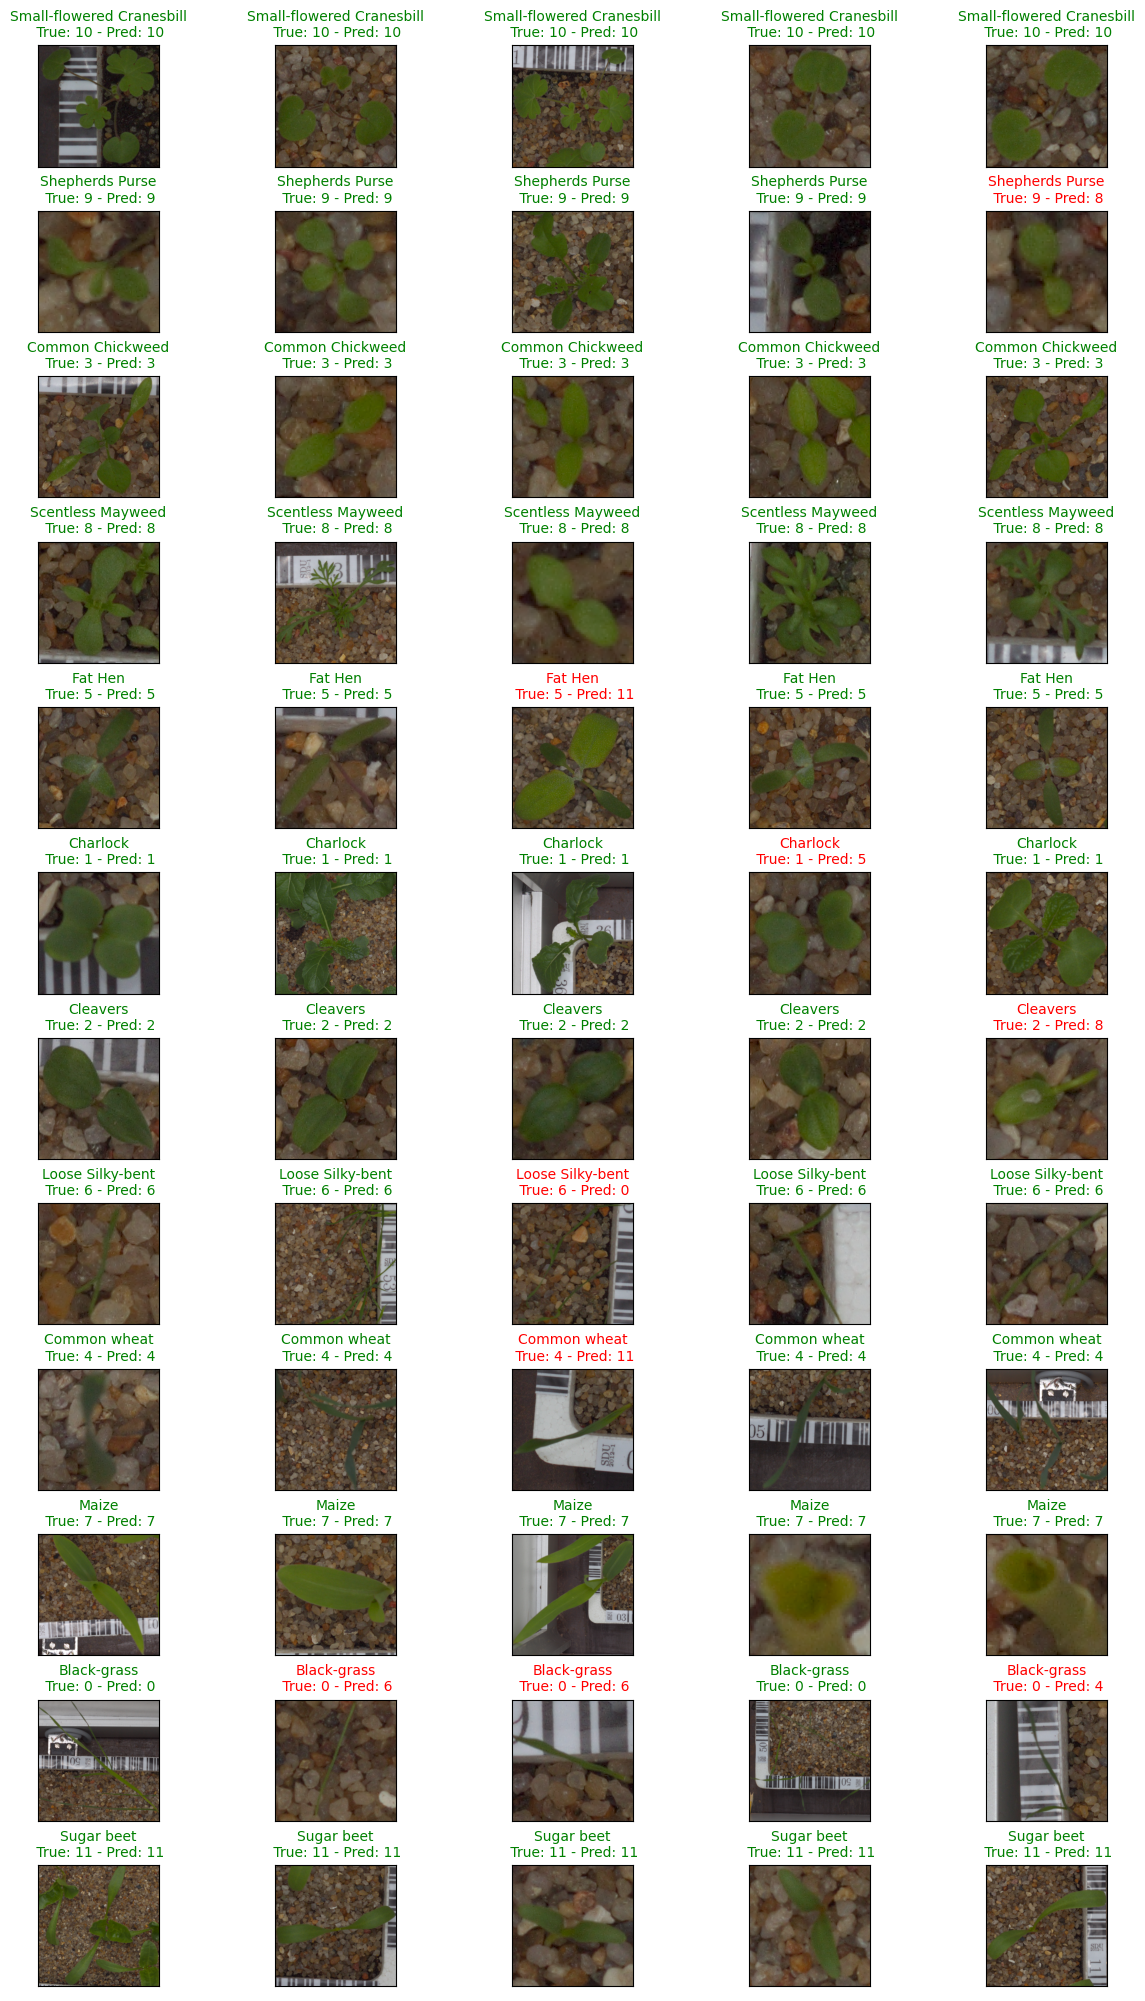

In [59]:
plot_example_predictions('valid_data')

# Apply Model to Test Set

Now, that we have a trained model, we can apply it to the test set. For that, we have to prepare the data the exact same way as we did for the validation. In this notebook, we have the model already loaded. In a real world case, we would have to read it. To pretend this to be more realistic we instantiate the model again and load it.

In [40]:
model = PlantClassifier().to(device)
model.load_state_dict(torch.load(f"{model.__class__.__name__}_best_model.pth"))
model.eval()

PlantClassifier(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
    

Make predictions of the test set images.

In [60]:
def make_predictions(data_path):
    pred_labels = []
    images = glob.glob(f"{data_path}/*.png")
    imgs = [cv2.imread(img) for img in images]
    for j in range(len(imgs)):
        img = imgs[j]
        rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_transf = valid_transforms(rgb_img)[None,]
        y_hat = model(img_transf)
        pred = y_hat.argmax(dim=-1, keepdims=True).detach().cpu().numpy()
        pred_labels.append((img, pred))
    return pred_labels

In [61]:
pred_labels = make_predictions(os.path.join(data_path, 'test'))

In [62]:
print(f'We have {len(pred_labels)} test images.')

We have 794 test images.


**Example Plots**

In [63]:
def plot_example_predictions_test(pred_labels):
    fig, axes = plt.subplots(5, 5, figsize=(12,12))
    pred_sel = random.sample(pred_labels, 25)
    for j in range(25):
        img = np.array(pred_sel[j][0])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        pred = pred_sel[j][1].flatten()[0]
        axes.flatten()[j].imshow(img)
        axes.flatten()[j].set_title(f'Pred: {train_data.classes[pred]}',
                                    fontsize=10)
        axes.flatten()[j].set_xticks([])
        axes.flatten()[j].set_yticks([]);

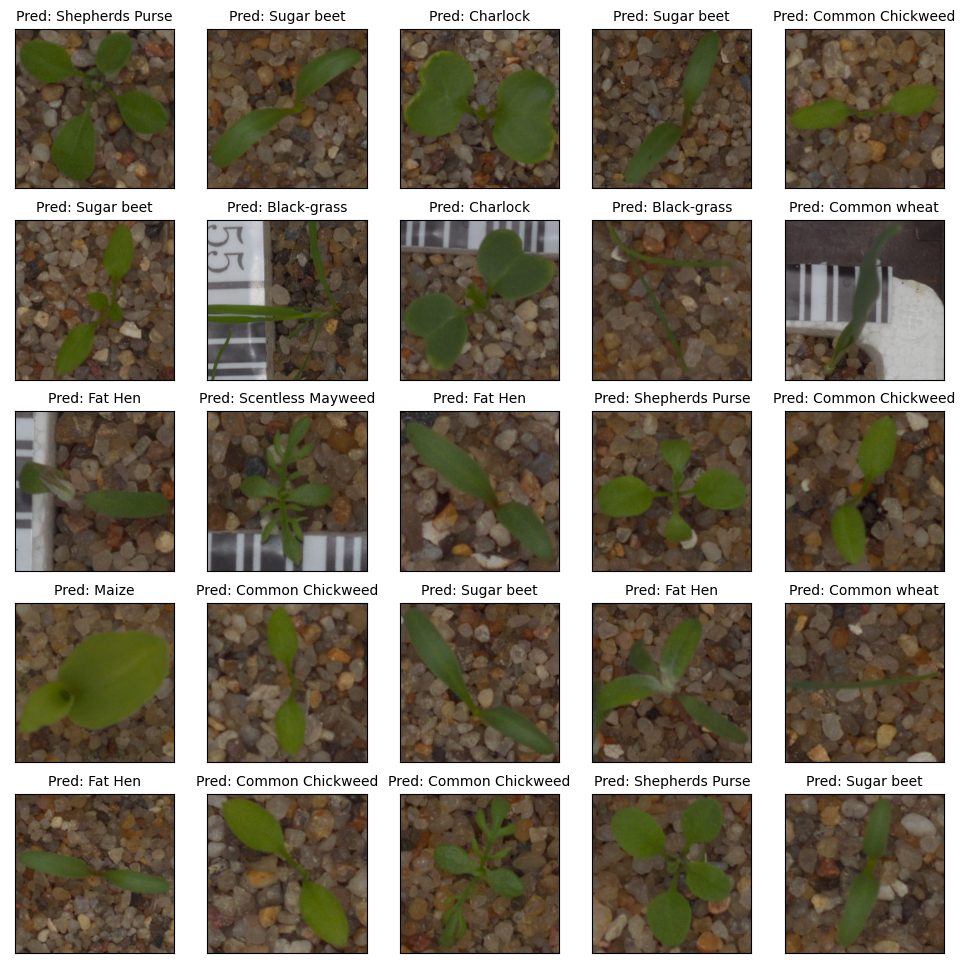

In [64]:
plot_example_predictions_test(pred_labels)

# Summary & Conclusions 

We were able to develop a model to classify 12 different plants by images of these plants at different growth stages. This model is based on the VGG16 model adapted for our use case. The images were preprocessed such that their background was removed before training in order to remove artifacts that may irritate the model. Overall we achieved good results with a meanFScore of 0.87.

A difficulty in this task was that the data is not equally distributed over all classes. We used data augmentation and weighted loss to overcome this problem.  I tried both options: Training with and without class weights and using class weights lead to slightly lower loss. However this small difference might also be due to some randomness during training. Although in both cases the overall model metrics were similar, however a difference in the accuracy distribution over the classes could be seen. In the model without class weights a very low accuracy for 'Black grass' was observed, with only 15%. In general a higher accuracy was found for classes with a higher number of images available. When adding the class weights this changed and the accuracies were more evenly distributed over the classes. The results show that the model has particular problems to distinguish 'Black-grass', 'Loose Silky-bent', and 'common wheat'. These three plants are visually very similar. 

Options to further improve the model are, e.g. augmenting data especially for classes the model has difficulies to predict correctly by taking more fotos, if possible. The data could also be augmented artificially by similar methods as performed in the transformations (like e.g. flipping or rotating) before the training starts in order to have the same number of images for each class and in that way overcome the class imbalance. Other ideas are more data augmentation during training, to try other hyperparamters, like batch-size, learning rate or the model itself, e.g. changing layers in the classifier from the VGG16 we adapted, or to try other loss functions, like the focal loss, that emphazises classes which are difficult to classify.

Unfortunately, I was not able to access GPU runtime during the time working on this challenge, so I couldn't train the model very often or try different hyperparamters etc.